In [76]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
from astroduet.duet_sensitivity import calc_exposure
import numpy as np
from matplotlib import pyplot as plt
from astroduet.bbmag import bb_abmag_fluence, bb_abmag
from astroduet.utils import get_neff

import astroduet.config as config
from astroduet.background import background_pixel_rate


from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
duet = config.Telescope()
duet.config_list

['baseline',
 'classic',
 'minimum_mass',
 'fine_plate',
 'equal_mass',
 'largest_aperture',
 'reduced_baseline']

In [97]:
duet.update_psf()
duet.psf_fwhm

<Quantity 5. arcsec>

Text(0, 0.5, 'Fraction of Eclosed Energy')

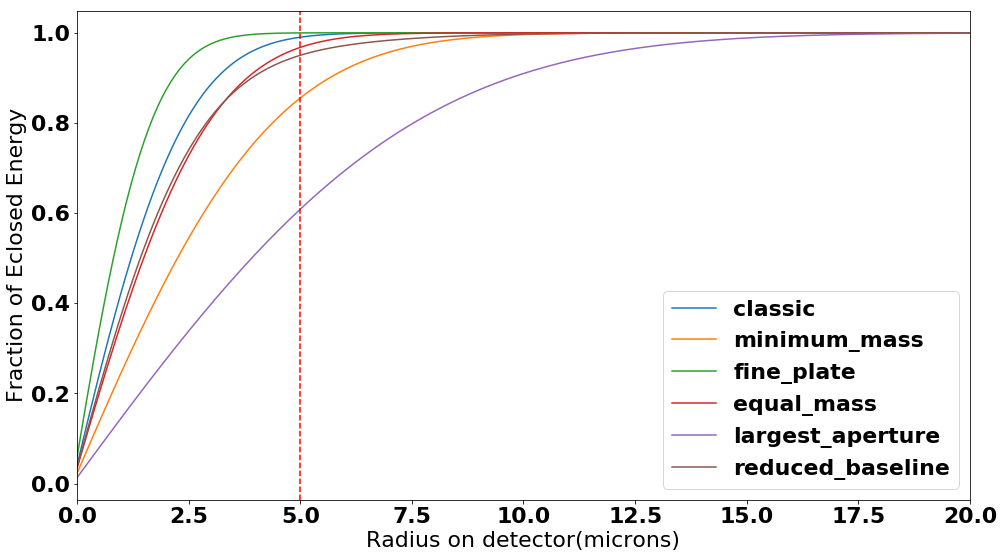

In [135]:
f = plt.figure(figsize=[16, 9])
for ind, tel_type in enumerate(duet.config_list):
    if ind == 0:
        continue

    duet = config.Telescope(config=tel_type)

    pix, radpro = duet.calc_radial_profile()
    psf = duet.psf_model()
    rind = np.arange(0,len(radpro))*pix
    eef = np.cumsum(radpro)
    plt.plot(rind, eef /eef.max(), label=duet.config)
    plt.xlim([0, 20])
plt.legend()
plt.axvline(x=5., linestyle = '--', color ='r')
plt.xlabel('Radius on detector(microns)')
plt.ylabel('Fraction of Eclosed Energy')


In [151]:
# FOM: Time to 22 ABmag for this configuration for DUET1
# Old FOM for this 

siglimit=10
swiftmag = 21
dmag = 0.05
bbmag1 = 5*u.ABmag
bbmag_target = 21.8*u.ABmag

duet = config.Telescope(config='classic')
bandone = duet.bandpass1
bandtwo = duet.bandpass2
while bbmag1 < bbmag_target:
    swiftmag+=dmag
    bbmag1, bbmag2 = bb_abmag(swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K, bandone = bandone, bandtwo=bandtwo)
print(f"""-----
        Swift AB mag {swiftmag}
        DUET1 AB mag {bbmag1}
        DUET2 AB mag {bbmag2}""")



for ind, tel_type in enumerate(duet.config_list):
    if ind == 0:
        continue

    print()
    duet = config.Telescope(config=tel_type)
    duet.read_noise=3
    

#    duet.config, duet.psf_fwhm, duet.neff)

    siglimit=10
    bandone = duet.bandpass1
    bandtwo = duet.bandpass2

#     # Low Zodi, 10-sigma case
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
    print('Low-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, med_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
    print('Med-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    print('Med-Zodi {}-sig, {} FoM min'.format(siglimit, 2*req_exp.value/60.))
    print('Med-Zodi {}-sig, {} 300-s frames'.format(siglimit, 2*req_exp.value/300.))

    # High Zodi, 10-sigma case.
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#    print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))

    print(f"""-----
        Config: {duet.config}
        PSF: {duet.psf_fwhm}
        Pixel: {duet.pixel}
        Neff: {duet.neff}
        Frame Duration: {req_exp.value}
        FOM (minutes to survey error box): {2*req_exp.value/60.}
    """)
#    print('High-Zodi {}-sig, {} FoM min'.format(siglimit, 2*req_exp.value/60.))


#     # High Zodi, 5-sigma case
#     siglimit=10
#     [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
#     band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
#     band1_rate = duet.fluence_to_rate(band1_fluence)

#     req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#     print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    



-----
        Swift AB mag 21.80000000000001
        DUET1 AB mag 21.800470091092393 mag(AB)
        DUET2 AB mag 21.388257363507947 mag(AB)

Low-Zodi 10-sig, 385.62741337054615 seconds
Med-Zodi 10-sig, 422.50812144347634 seconds
Med-Zodi 10-sig, 14.083604048115879 FoM min
Med-Zodi 10-sig, 2.8167208096231757 300-s frames
-----
        Config: classic
        PSF: 4.6 arcsec
        Pixel: 6.25 arcsec
        Neff: 3.915397310924053
        Frame Duration: 749.8648652445595
        FOM (minutes to survey error box): 24.995495508151983
    

Low-Zodi 10-sig, 452.5934116689753 seconds
Med-Zodi 10-sig, 514.7014692279328 seconds
Med-Zodi 10-sig, 17.156715640931093 FoM min
Med-Zodi 10-sig, 3.4313431281862186 300-s frames
-----
        Config: minimum_mass
        PSF: 8.2 arcsec
        Pixel: 6.67 arcsec
        Neff: 5.816888480720367
        Frame Duration: 1074.117250033549
        FOM (minutes to survey error box): 35.803908334451634
    

Low-Zodi 10-sig, 391.37100625216965 seconds
Med